# Sifting through results of the parameter search (adaptation)

This notebook is almost an exact copy of D2a. The only difference is that this notebook processing experiments with adaptation. I wil leave the notebook mostly uncommented for that reason.

This notebook searches the experiment brute-forced in notebook D1, looking for networks that 'stably' propagate spike pulses.

Specifically, the criteria for 'stable' spike pulse propagation are:
1. Spikes occur in the final link of the chain OR there is spiking activity is still ongoing as the simulation ends.
2. The mean number of spike counts per link is greater than (5 * number of neurons per link) and less than (7 * number of neurons per link).
3. The standard derivation of spike counts per link is less than 30% of the mean spike count per link.
4. The standard deviation of the standard derivation of spike times per link is less than 30% of the mean of the standard deviation of spike times per link.

## Hyperparameters

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import pickle
import datetime
import os
import pandas as pd

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

from utils.general import *
from utils.file_io import *

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=1.6e-3,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, T_E=.002, T_I=.002,

    # NTWK ARCHITECTURE
    N_L=40,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    W_E_E_R=0.005e-3,  # E-E recurrent cxns w/in chain link
    W_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    W_U_E_I=0.05e-3,  # I->E input weights
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s)) 
    I_EXT_B=0,  # additional baseline current input
)

# Sifting through results of the parameter search
Here's some code to load batches of experiments

### Helper functions

In [2]:
def spk_tms_for_link(spks_t, spks_c, idx, n_l_e):
    link_start_idx = idx * n_l_e
    window = (spks_c >= link_start_idx) & (spks_c < (link_start_idx + n_l_e))
    return spks_t[window]

def tms_for_link(spks_t, spks_c, n_l, n_l_e):
    return [spk_tms_for_link(spks_t, spks_c, i, n_l_e) for i in range(n_l)]

def last_spk_tm(tms_p_link):
    l = len(tms_p_link)
    for i in range(l):
        tms_for_link = tms_p_link[l - i - 1]
        if len(tms_for_link) > 0:
            return tms_for_link[-1]

### Define functions for loading and scanning experiments for interesting results by batch

In [3]:
def load_batches(batch_path):
    fs = [f for f in sorted(all_files_with_name_frags(batch_path, 'batch_'))]
    for f_idx, f in enumerate(fs):
        batch_data = pickle.load(open(os.path.join(batch_path, f), 'rb'))
        yield batch_data

def process_single_exp(experiment_results, m):
    x = np.arange(m.N_L) + 1
    results = []
    
    experiment_results = experiment_results[0] if type(experiment_results) is list else experiment_results

    tms_p_link = tms_for_link(experiment_results['spks_t'], experiment_results['spks_c'], m.N_L, m.N_L_E)
    mean_tms_p_link = np.array([np.mean(tms_for_link) for tms_for_link in tms_p_link])
    std_tms_p_link = np.array([np.std(tms_for_link) for tms_for_link in tms_p_link])

    mean_of_std = np.mean(std_tms_p_link[~np.isnan(std_tms_p_link)])
    std_of_std = np.std(std_tms_p_link[~np.isnan(std_tms_p_link)])

    counts_per_link = np.array(map_to_list(lambda l: l.size, tms_p_link))
    mean_cnts_p_link = np.mean(counts_per_link[counts_per_link > 0])
    std_cnts_p_link = np.std(counts_per_link[counts_per_link > 0])

    if ((len(tms_p_link[-1]) == 0 and (last_spk_tm(tms_p_link) < (.3 - 0.01)))
        or std_of_std / mean_of_std > 0.3
        or std_cnts_p_link / mean_cnts_p_link > 0.3
        or mean_cnts_p_link > 7 * m.N_L_E
        or mean_cnts_p_link < 5 * m.N_L_E):
        return None
    
    slp, icpt = stats.linregress(x, mean_tms_p_link)[:2]
    return [mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link]

def parse_param_results(all_results_for_params, m):
    if type(all_results_for_params[0]) is list:
        l = len(all_results_for_params)
        processed = [process_single_exp(res, m) for res in all_results_for_params]
        for el in processed:
            if el is None:
                return None
        return processed
    else:
        processed = process_single_exp(all_results_for_params, m)
        if processed is not None:
            return [processed]
        
def scan_batch(batch_results, batch_params, m, batch_idx):
    x = np.arange(m.N_L) + 1
    passing_scan = []

    for r in zip(batch_results, batch_params):
        (all_results_for_params, params) = r
        processed = parse_param_results(all_results_for_params, m)
        if processed is not None:
            passing_scan.append((params, processed))

    return passing_scan
    for idx, (params, processed) in enumerate(passing_scan):
        print(params)
        
        (mean_tms_p_link, std_tms_p_link, slp, icpt, tms_p_link) = processed[0]
        gs = gridspec.GridSpec(2, 1)
        fig = plt.figure(figsize=(10, 10), tight_layout=True)
        axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
        axs[0].set_title(f'index: {batch_idx}{idx} params:' + ' '.join(map_to_list(lambda p_i: f'{p_i}', params)))
        axs[0].fill_between(x, mean_tms_p_link - std_tms_p_link, mean_tms_p_link + std_tms_p_link, color='red', alpha=0.25)
        axs[0].scatter(x, mean_tms_p_link, s=3, c='red')
        axs[0].set_ylim(0, 0.3)
        axs[0].set_xlim(0, m.N_L)

        for l_cntr in range(m.N_L):
            y = l_cntr * np.ones(len(tms_p_link[l_cntr])) + 1
            axs[1].scatter(tms_p_link[l_cntr], y + .2 * np.random.randn(len(y)), s=5, c='black', zorder=0)
            axs[1].set_ylim(0, m.N_L)
        print('')


In [17]:
batch_path = './data/exp_2020-07-03--10:38'

params = pickle.load(open(os.path.join(batch_path, 'params.p'), 'rb'))
config = pickle.load(open(os.path.join(batch_path, 'config.p'), 'rb'))

results_meeting_criteria = []

for batch_idx, batch_data in enumerate(load_batches(batch_path)):
    batch_start = batch_idx * config['batch_size']
    batch_end = np.min([batch_start + config['batch_size'], len(params)])
    results_meeting_criteria.append(scan_batch(batch_data, params[batch_start:batch_end], M, batch_idx))

In [18]:
print(len(results_meeting_criteria))
data = {'weer': [], 'weef': [], 'cxneep': []}

320


In [19]:
for batch in results_meeting_criteria:
    if len(batch) is not 0:
        params = batch[0][0]
        data['weer'].append(params[2])
        data['weef'].append(params[3])
        data['cxneep'].append(params[5])

In [20]:
df = pd.DataFrame(data=data)

0.08
             weer      weef  cxneep
2    3.512605e-07  0.000028    0.08
6    1.105042e-06  0.000028    0.08
10   1.858824e-06  0.000028    0.08
20   3.366387e-06  0.000028    0.08
37   5.627731e-06  0.000028    0.08
50   7.135294e-06  0.000028    0.08
58   7.889076e-06  0.000028    0.08
65   8.642857e-06  0.000028    0.08
69   9.145378e-06  0.000025    0.08
72   9.396639e-06  0.000028    0.08
80   1.015042e-05  0.000028    0.08
88   1.090420e-05  0.000028    0.08
96   1.165798e-05  0.000028    0.08
104  1.241176e-05  0.000028    0.08
112  1.316555e-05  0.000028    0.08
120  1.391933e-05  0.000028    0.08
125  1.442185e-05  0.000026    0.08
128  1.467311e-05  0.000028    0.08
133  1.517563e-05  0.000025    0.08
136  1.542689e-05  0.000028    0.08
141  1.592941e-05  0.000026    0.08
144  1.618067e-05  0.000028    0.08
149  1.668319e-05  0.000025    0.08
152  1.693445e-05  0.000028    0.08
157  1.743697e-05  0.000026    0.08
160  1.768824e-05  0.000028    0.08
168  1.844202e-05  0.00

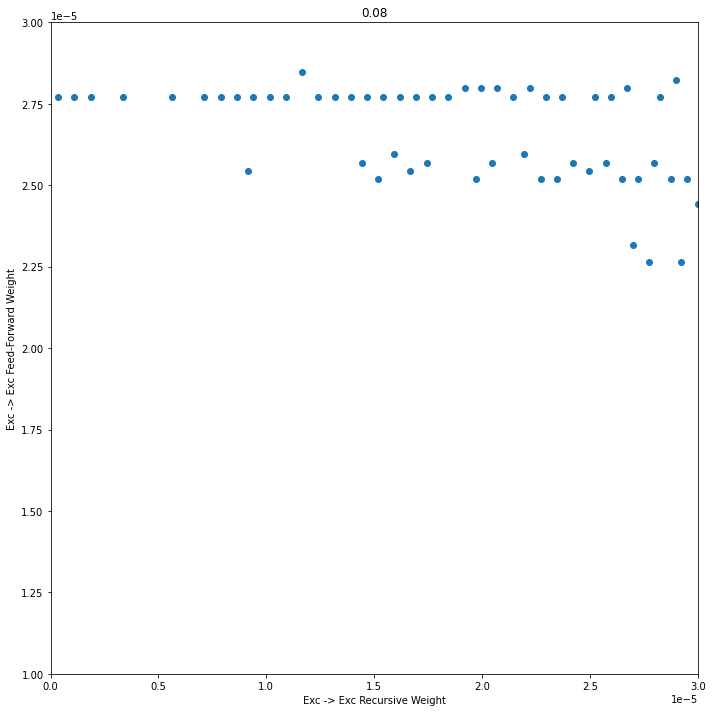

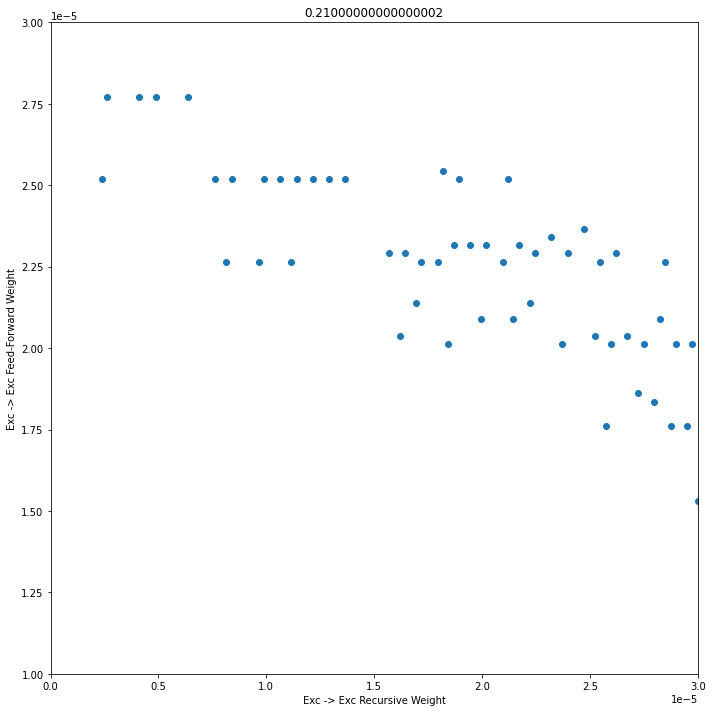

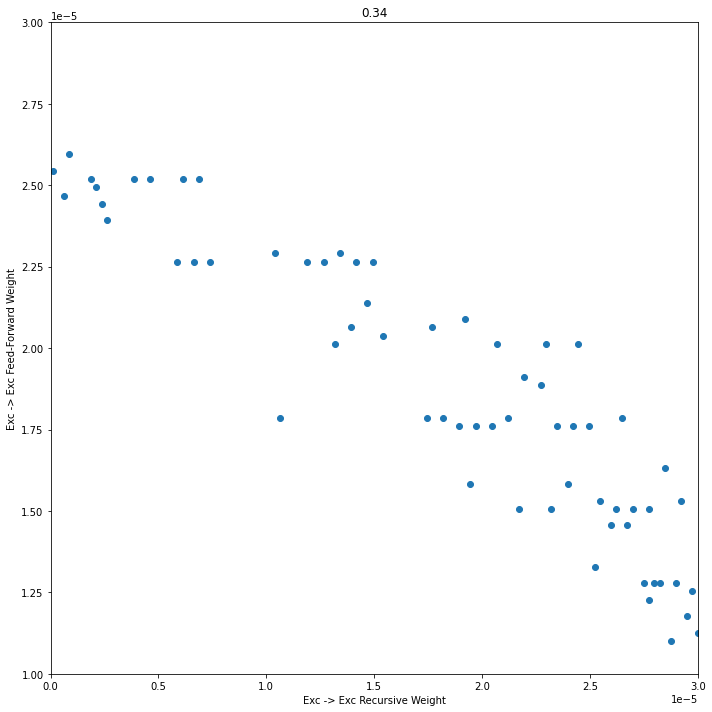

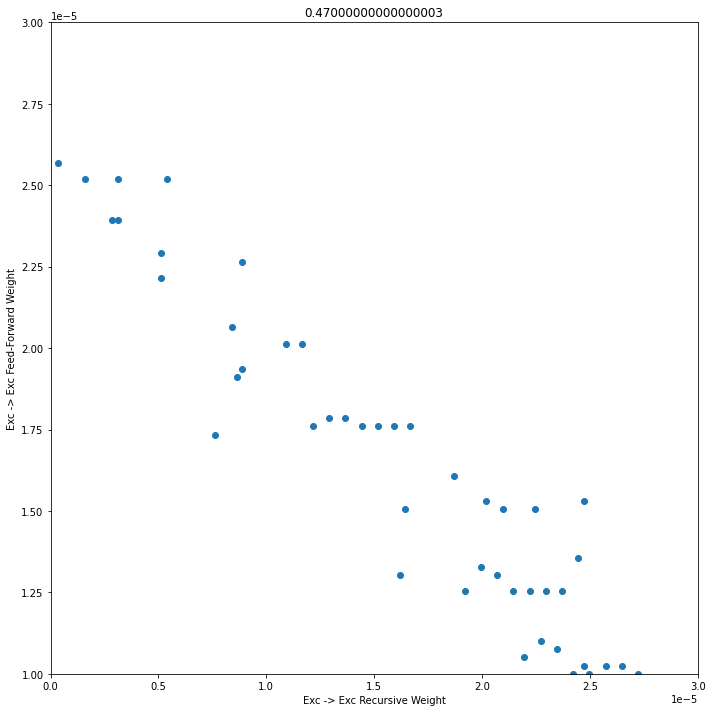

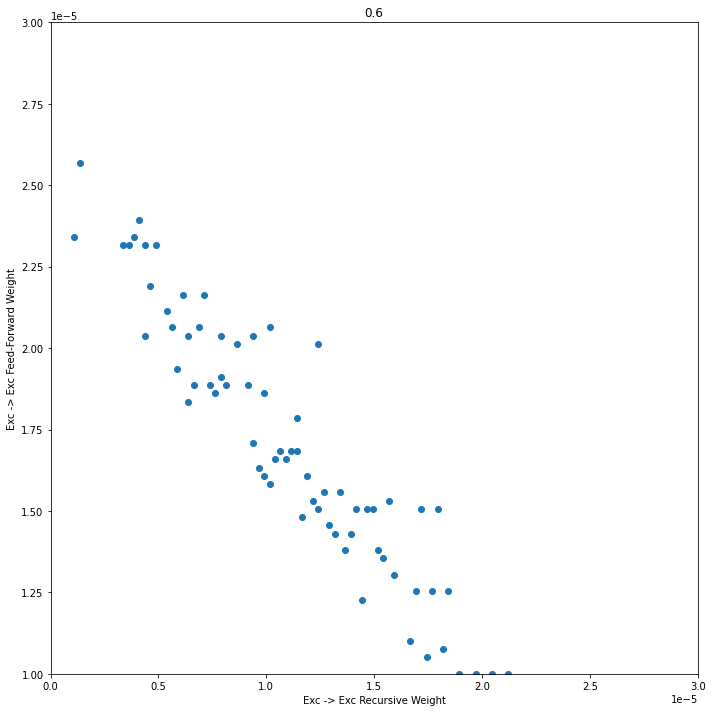

In [23]:
pd.set_option('display.max_rows', 500)

for cxn in sorted(df['cxneep'].unique()):
    df_for_cxn = df[df['cxneep'] == cxn]
    print(cxn)
    print(df_for_cxn)
    
    pickle.dump(df_for_cxn, open(f'./data/exp_2020-07-03--10:38/stable_weights_per_{str(cxn)[2:5]}.p', 'wb'))
    
    gs = gridspec.GridSpec(1, 1)
    fig = plt.figure(figsize=(10, 10), tight_layout=True)
    ax = fig.add_subplot(gs[0])
    ax.scatter(df_for_cxn['weer'], df_for_cxn['weef'])

    ax.set_ylim(10e-6, 30.0e-6)
    ax.set_ylabel('Exc -> Exc Feed-Forward Weight')
    ax.set_xlim(0, 30.0e-6)
    ax.set_xlabel('Exc -> Exc Recursive Weight')
    ax.set_title(f'{cxn}')
    
    